In [248]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import date
import statistics
from IPython.display import Markdown
import calmap

In [304]:
# Load our CSV file into a dataframe.
time_entries = pd.read_csv(
    "toggl.csv", 
    parse_dates=["Start date", "End date"],
    date_format="%Y-%m-%d",
)
print(f'Data has {time_entries.shape[0]} rows and {time_entries.shape[1]} columns')
time_entries.head()

Data has 1358 rows and 14 columns


,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags,Amount ()
0,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-28,12:30:00,2022-10-28,13:30:00,01:00:00,NaN,NaN
1,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-28,10:00:00,2022-10-28,10:45:00,00:45:00,NaN,NaN
2,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-27,20:30:00,2022-10-27,21:45:00,01:15:00,NaN,NaN
3,Stefan Kussmaul,NaN,NaN,Guitar,NaN,Practice,No,2022-10-27,19:30:00,2022-10-27,20:00:00,00:30:00,NaN,NaN
4,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-27,16:45:00,2022-10-27,18:15:00,01:30:00,NaN,NaN


In [305]:
# Filter data by date (`start_date` inclusive, `end_date` exclusive).
start_date = '2021-10-01'
end_date = '2022-11-01'
time_entries = time_entries[(time_entries['Start date'] >= start_date) & (time_entries['End date'] < end_date)]
print(f'Data has {time_entries.shape[0]} rows after filtering.')
time_entries.head()

Data has 1353 rows after filtering.


,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags,Amount ()
0,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-28,12:30:00,2022-10-28,13:30:00,01:00:00,NaN,NaN
1,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-28,10:00:00,2022-10-28,10:45:00,00:45:00,NaN,NaN
2,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-27,20:30:00,2022-10-27,21:45:00,01:15:00,NaN,NaN
3,Stefan Kussmaul,NaN,NaN,Guitar,NaN,Practice,No,2022-10-27,19:30:00,2022-10-27,20:00:00,00:30:00,NaN,NaN
4,Stefan Kussmaul,NaN,NaN,Master's Thesis,NaN,Work,No,2022-10-27,16:45:00,2022-10-27,18:15:00,01:30:00,NaN,NaN


In [306]:
# Drop unneeded columns.
time_entries = time_entries.drop(['User', 'Email', 'Client', 'Task', 'Billable', 'Tags', 'Amount ()'], axis=1)

# Toggl provides the data with dates and times separated. We need to combine them back together.
# First, we convert the "Start time" and "End time" columns to `pandas.dt.time`. 
time_entries['Start time'] = pd.to_datetime(time_entries['Start time'], format="%H:%M:%S").dt.time
time_entries['End time'] = pd.to_datetime(time_entries['End time'], format="%H:%M:%S").dt.time
# Then we use `pd.Timestamp.combine()` to combine the date and time columns into new column called "Start" and "End". 
time_entries['Start'] = time_entries.apply(lambda x: pd.Timestamp.combine(x['Start date'], x['Start time']), axis=1)
time_entries['End'] = time_entries.apply(lambda x: pd.Timestamp.combine(x['End date'], x['End time']), axis=1)
# Finally, we remove the original columns.
time_entries = time_entries.drop(['Start date', 'Start time', 'End date', 'End time'], axis=1)

# Recalculate the "Duration" column so that we get instances of `pandas.Timedelta`.
time_entries['Duration'] = time_entries['End'] - time_entries['Start']

time_entries.head()

,Project,Description,Duration,Start,End
0,Master's Thesis,Work,0 days 01:00:00,2022-10-28 12:30:00,2022-10-28 13:30:00
1,Master's Thesis,Work,0 days 00:45:00,2022-10-28 10:00:00,2022-10-28 10:45:00
2,Master's Thesis,Work,0 days 01:15:00,2022-10-27 20:30:00,2022-10-27 21:45:00
3,Guitar,Practice,0 days 00:30:00,2022-10-27 19:30:00,2022-10-27 20:00:00
4,Master's Thesis,Work,0 days 01:30:00,2022-10-27 16:45:00,2022-10-27 18:15:00


In [307]:
# Add a tag to each entry stating whether it's work-related, study-related, or hobby-related.
def get_tag(project_name: str) -> str:
    if project_name in ('QPLIX', 'Career'):
        return 'Work'
    elif project_name in ('AI', 'Data Engineering', 'Distributed Systems', "Master's Thesis", 'Other Uni'):
        return 'Study'
    elif project_name in ('Guitar', 'Personal Projects', 'Sport'):
        return 'Hobby'
    else:
        raise ValueError(f'Unhandled project: "{project_name}".')

time_entries['Tag'] = time_entries.apply(lambda r: get_tag(r['Project']), axis=1)
time_entries

,Project,Description,Duration,Start,End,Tag
0,Master's Thesis,Work,0 days 01:00:00,2022-10-28 12:30:00,2022-10-28 13:30:00,Study
1,Master's Thesis,Work,0 days 00:45:00,2022-10-28 10:00:00,2022-10-28 10:45:00,Study
2,Master's Thesis,Work,0 days 01:15:00,2022-10-27 20:30:00,2022-10-27 21:45:00,Study
3,Guitar,Practice,0 days 00:30:00,2022-10-27 19:30:00,2022-10-27 20:00:00,Hobby
4,Master's Thesis,Work,0 days 01:30:00,2022-10-27 16:45:00,2022-10-27 18:15:00,Study
...,...,...,...,...,...,...
1348,Guitar,Practice,0 days 00:45:00,2021-10-06 20:00:00,2021-10-06 20:45:00,Hobby
1349,Guitar,Practice,0 days 01:00:00,2021-10-05 21:00:00,2021-10-05 22:00:00,Hobby
1350,Sport,Tennis,0 days 01:30:00,2021-10-03 15:00:00,2021-10-03 16:30:00,Hobby
1351,Guitar,Practice,0 days 00:45:00,2021-10-02 21:30:00,2021-10-02 22:15:00,Hobby


In [308]:
# Generate a Markdown table with some basic statistics.
table = "| Project | Num Entries | Time Tracked | Avg. Duration |\n"
table += "| --- | --- | --- | --- |\n"
# Group by project and iterate over the results. 
# `groupby()` provides us with a dataframe of time entries for each project. 
for project_name, project_entries in time_entries.groupby('Project'):
    time_tracked = project_entries['Duration'].sum().total_seconds()
    avg_duration = project_entries['Duration'].mean().total_seconds()
    table += f"| {project_name} | {len(project_entries)} | {int(time_tracked // 3600)} hours | {int(avg_duration // 60)} min |\n"

total_time = time_entries['Duration'].sum().total_seconds()
avg_duration = int(total_time / len(time_entries))
table += f"| **Total** | **{len(time_entries)}** | **{int(total_time // 3600)} hours** | **{int(avg_duration // 60)} min** |\n"

Markdown(table)

| Project | Num Entries | Time Tracked | Avg. Duration |
| --- | --- | --- | --- |
| AI | 62 | 92 hours | 89 min |
| Career | 169 | 223 hours | 79 min |
| Data Engineering | 80 | 114 hours | 85 min |
| Distributed Systems | 14 | 23 hours | 99 min |
| Guitar | 172 | 101 hours | 35 min |
| Master's Thesis | 358 | 476 hours | 79 min |
| Other Uni | 92 | 138 hours | 90 min |
| Personal Projects | 181 | 267 hours | 88 min |
| QPLIX | 84 | 213 hours | 152 min |
| Sport | 141 | 171 hours | 72 min |
| **Total** | **1353** | **1822 hours** | **80 min** |


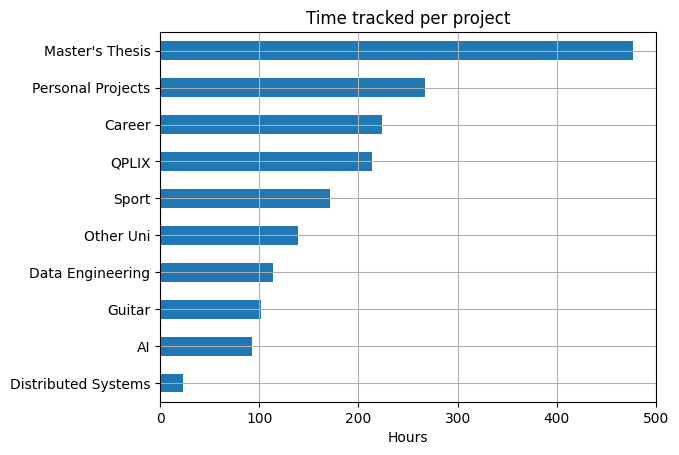

In [309]:
# Make a simple bar plot of time spent per project.
time_spent = time_entries.groupby('Project')['Duration'].sum().dt.total_seconds() / 3600
time_spent.sort_values(inplace=True)

ax = time_spent.plot.barh()
ax.set_title('Time tracked per project')
ax.set_xlabel('Hours')
ax.set_ylabel('')
ax.grid()

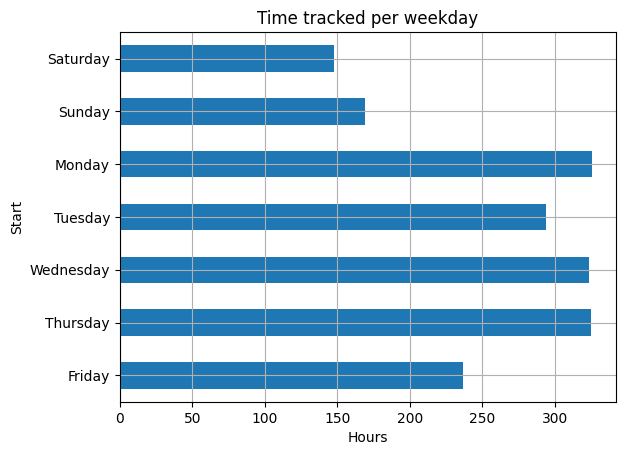

In [310]:
# Group time entries by the weekday on which they were recorded.
per_weekday = time_entries.groupby(time_entries['Start'].dt.day_name(), sort=False)['Duration'].sum().dt.total_seconds() / 3600
ax = per_weekday.plot.barh()
ax.set_title('Time tracked per weekday')
ax.set_xlabel('Hours')
ax.grid()

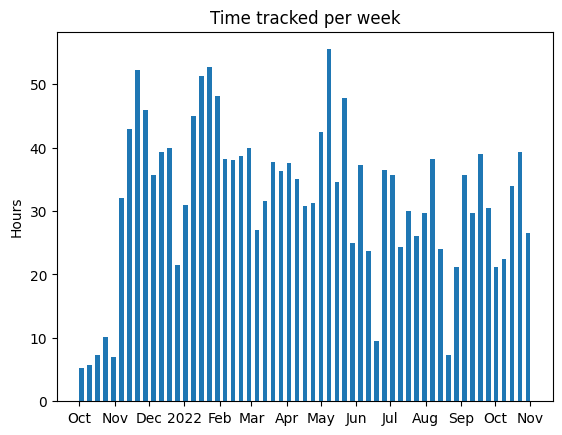

In [312]:
# Calculate the total time tracked per week.
# We use a Grouper for this. See https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
per_week = time_entries.groupby(pd.Grouper(key="Start", freq="1W"))['Duration'].sum().dt.total_seconds() / 3600
fig, ax = plt.subplots()
ax.bar(per_week.index, per_week.values, width=pd.Timedelta(4, "d"))
ax.set_title('Time tracked per week')
ax.set_ylabel('Hours')

# Configure the plot to only show ticks on each Month and ot have concise labels.
# See https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

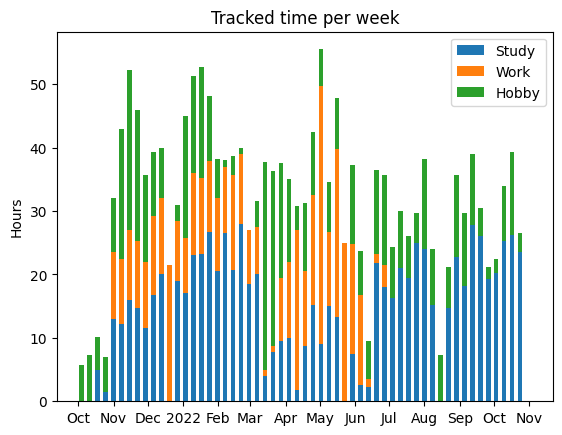

In [313]:
# Create a stacked bar plot that breaks down the time spent per tag.
# This is a bit tricky because our data doesn't necessarily have an entry for every week.

# Add a new column that stores the start time of the week that the entry occured in.
time_entries['week_start'] = time_entries['Start'].dt.to_period('W').apply(lambda r: r.start_time)
# Calculate the amount of time tracked per tag and per "week_start".
per_week = time_entries.groupby(['Tag', 'week_start'])['Duration'].sum().dt.total_seconds() / 3600

# The x-axis will have the date of every week between `start_date` and `end_date`, defined previously in the notebook.
# The dates should be aligned on Monday so that they match up with the `week_start` column we just calculated.
x_dates = pd.date_range(start_date, end_date, freq='W-MON')
# Calculate a running sum corresponding to `dates`. That means that the value in `running_sum[0]` will correspond to `dates[0]`.
# We use a list comprehension that simply assigns the value "0" for every value in dates. It's the same as [0 for i in range(len(dates))].
running_sum = [0 for _ in x_dates]

fig, ax = plt.subplots()
ax.set_title('Tracked time per week')
ax.set_ylabel('Hours')
for category in ['Study', 'Work', 'Hobby']:
    values = [0] * len(x_dates)
    # Look up the calculated time spent for `category` for each week.
    for i, week_start in enumerate(x_dates):
        values[i] = per_week[category].get(str(week_start.date()), 0)
    # Plot the result, setting "bottom" to make it stacked.
    ax.bar(x_dates, values, bottom=running_sum, width=pd.Timedelta(4, "d"), label=category)
    # Update running sum.
    for i, v in enumerate(values):
        running_sum[i] += v

ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>], dtype=object))

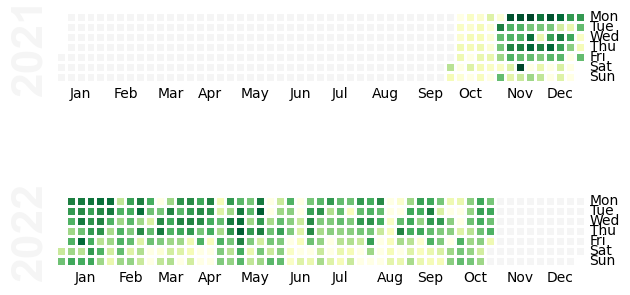

In [314]:
# Create a heatmap of time tracked per day.
per_day = time_entries.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(per_day, cmap='YlGn')

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>], dtype=object))

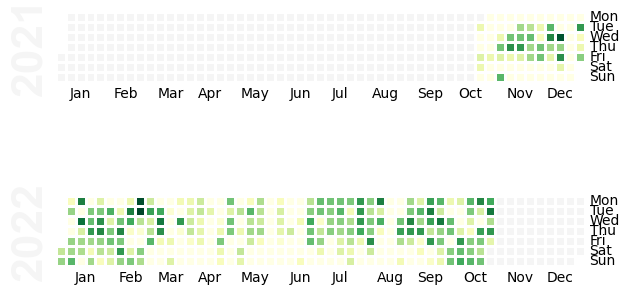

In [315]:
# Let's do another plot that only has study-related time entries.
work_and_study = time_entries[time_entries['Tag'] == 'Study']
work_per_day = work_and_study.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(work_per_day, cmap='YlGn')

In [316]:
# Calculate the total time spent on "Sport" entries, grouped by the description.
sports = time_entries[time_entries['Project'] == 'Sport']
sports.groupby('Description')['Duration'].sum().dt.total_seconds() / 3600

Description
Gym               35.75
Tennis           105.00
Tennis League     13.25
Tennis Lesson     17.50
Name: Duration, dtype: float64

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>], dtype=object))

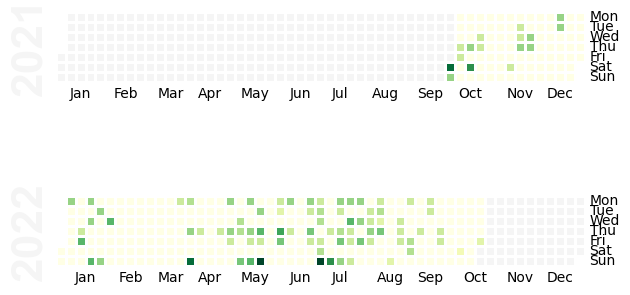

In [317]:
# Visualize how often I played tennis.
tennis = time_entries[(time_entries['Project'] == 'Sport') & (time_entries['Description'].str.contains('Tennis'))]
tennis_per_day = tennis.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(tennis_per_day, cmap='YlGn')

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>], dtype=object))

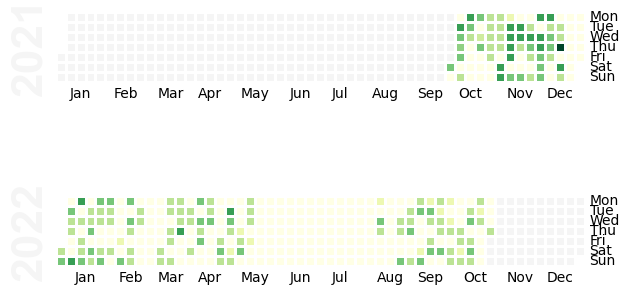

In [318]:
# Visualize how often I practiced guitar.
guitar = time_entries[(time_entries['Project'] == 'Guitar')]
guitar_per_day = guitar.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(guitar_per_day, cmap='YlGn')